In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from IMV_LSTM.networks import IMVFullLSTM

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
data = pd.read_csv("TS_datasets/pm25/PRSA_data_2010.1.1-2014.12.31.csv")

In [5]:
cbwd = pd.get_dummies(data['cbwd'])
cbwd.columns = ["cbwd_{}".format(i) for i in range(cbwd.shape[1])]
data = pd.concat([data, cbwd], axis=1)

In [6]:
data.drop(['cbwd'], axis=1, inplace=True)

In [7]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_0,cbwd_1,cbwd_2,cbwd_3
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


In [8]:
cols = list(data.columns[5:])

In [9]:
cols

['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_0',
 'cbwd_1',
 'cbwd_2',
 'cbwd_3']

In [10]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [11]:
depth = 10

In [12]:
X = np.zeros((len(data), depth, len(cols)))
for i, name in enumerate(cols):
    for j in range(depth):
        X[:, j, i] = data[name].shift(depth - j - 1).fillna(method='bfill')

In [13]:
y = data['pm2.5'].shift(-1).fillna(method='ffill').values

In [14]:
train_bound = int(0.6*(len(data)))
val_bound = int(0.8*(len(data)))

In [15]:
X_train = X[:train_bound]
X_val = X[train_bound:val_bound]
X_test = X[val_bound:]
y_train = y[:train_bound]
y_val = y[train_bound:val_bound]
y_test = y[val_bound:]

In [16]:
X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

In [17]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min +1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [18]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

In [35]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [26]:
model = IMVFullLSTM(X_train_t.shape[2], 1, 128).cuda()

In [27]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.046848041995156645 val:  0.024230528324479486
lr:  0.001
mse:  580.09424 mae:  13.0733


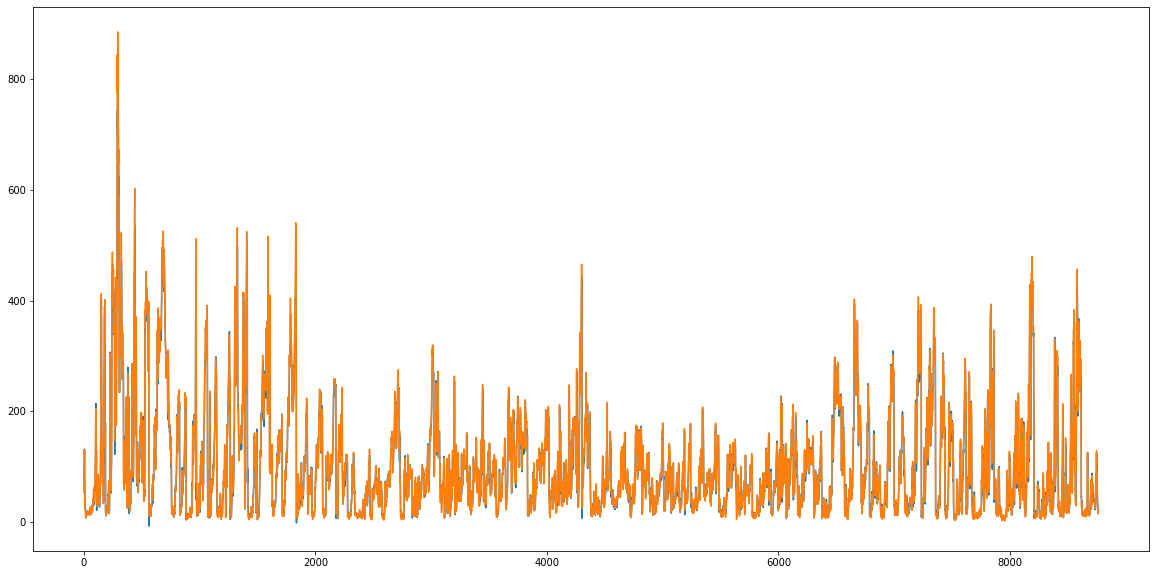

Iter:  1 train:  0.02404475869442557 val:  0.024524943377241433
Saving...
Iter:  2 train:  0.023670220269105792 val:  0.02379846478723958
Iter:  3 train:  0.023450188051735283 val:  0.0243369304379507
Iter:  4 train:  0.023138497672709802 val:  0.024637837085989822
Iter:  5 train:  0.023187735946344167 val:  0.0242307398998628
Iter:  6 train:  0.023057779878508385 val:  0.024506376990304182
Saving...
Iter:  7 train:  0.022985440214743993 val:  0.02367457330480345
Iter:  8 train:  0.02295616466229457 val:  0.0246190683923383
Iter:  9 train:  0.022787953535003236 val:  0.023940890067295294
Iter:  10 train:  0.022708027561929373 val:  0.024450889578846505
lr:  0.001
mse:  590.69336 mae:  13.55099


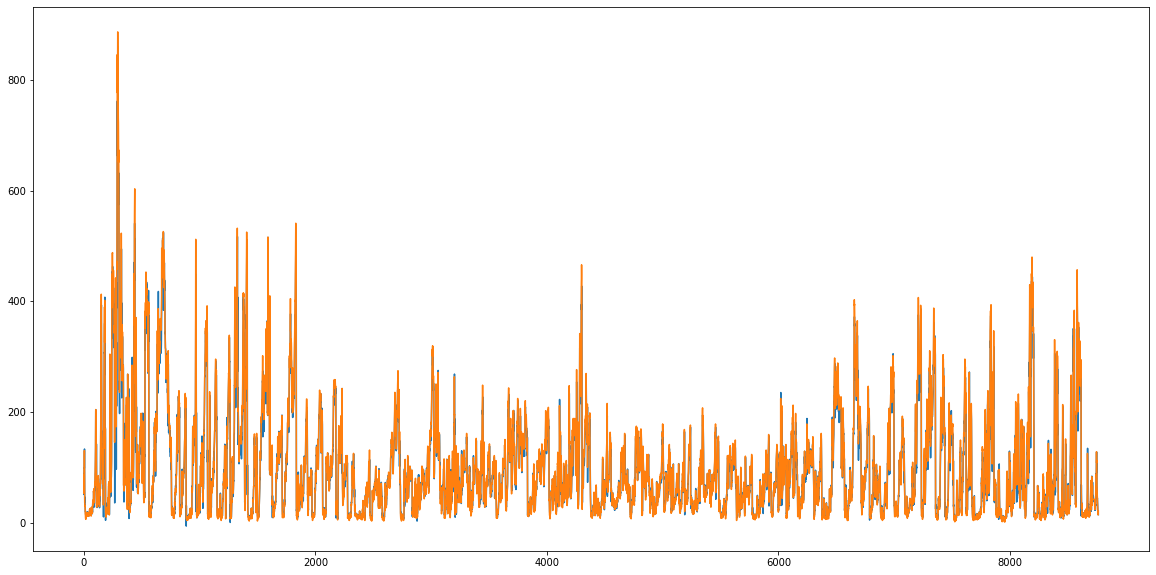

Iter:  11 train:  0.02274218095521283 val:  0.023946376304556358
Saving...
Iter:  12 train:  0.022718102854484733 val:  0.023556459569502884
Iter:  13 train:  0.022682718063259624 val:  0.023794106875032188
Iter:  14 train:  0.02253633928754588 val:  0.023598101803456315
Iter:  15 train:  0.02252656787941141 val:  0.024018952943350127
Saving...
Iter:  16 train:  0.02231734091382081 val:  0.023536543506650513
Iter:  17 train:  0.022276873474985286 val:  0.025253105413567112
Saving...
Iter:  18 train:  0.022246553947646103 val:  0.02344401457966006
Iter:  19 train:  0.022091538090093163 val:  0.023760492959675587
Iter:  20 train:  0.022066288660687654 val:  0.0235587407721078
lr:  0.0009000000000000001
mse:  548.374 mae:  12.843385


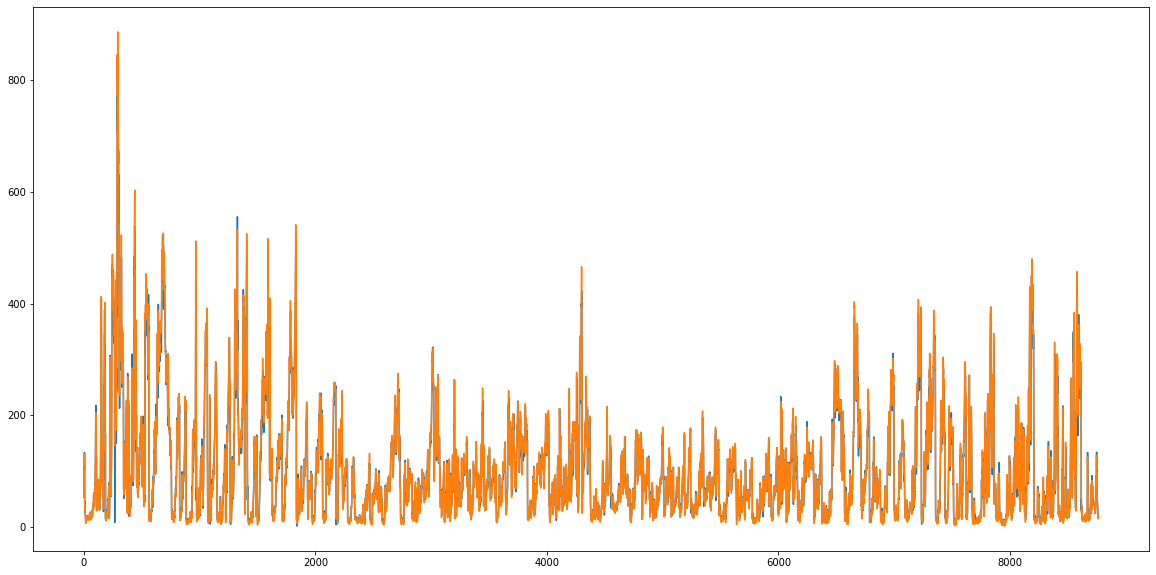

Iter:  21 train:  0.02202349367510094 val:  0.023517762820402275
Iter:  22 train:  0.021979372578476243 val:  0.023659571275353706
Iter:  23 train:  0.021837970323978346 val:  0.0236414517151441
Iter:  24 train:  0.02172797477754759 val:  0.02375881706027275
Iter:  25 train:  0.02195325562724555 val:  0.023967533464188742
Iter:  26 train:  0.02157711353319343 val:  0.023545321207946075
Iter:  27 train:  0.021601065364565693 val:  0.023796077740171687
Iter:  28 train:  0.021257077943736782 val:  0.02357789893353853
Iter:  29 train:  0.020980103990304196 val:  0.023546798333268063
Iter:  30 train:  0.020671891888701124 val:  0.02392674694375578
lr:  0.0009000000000000001
mse:  565.64 mae:  13.158564


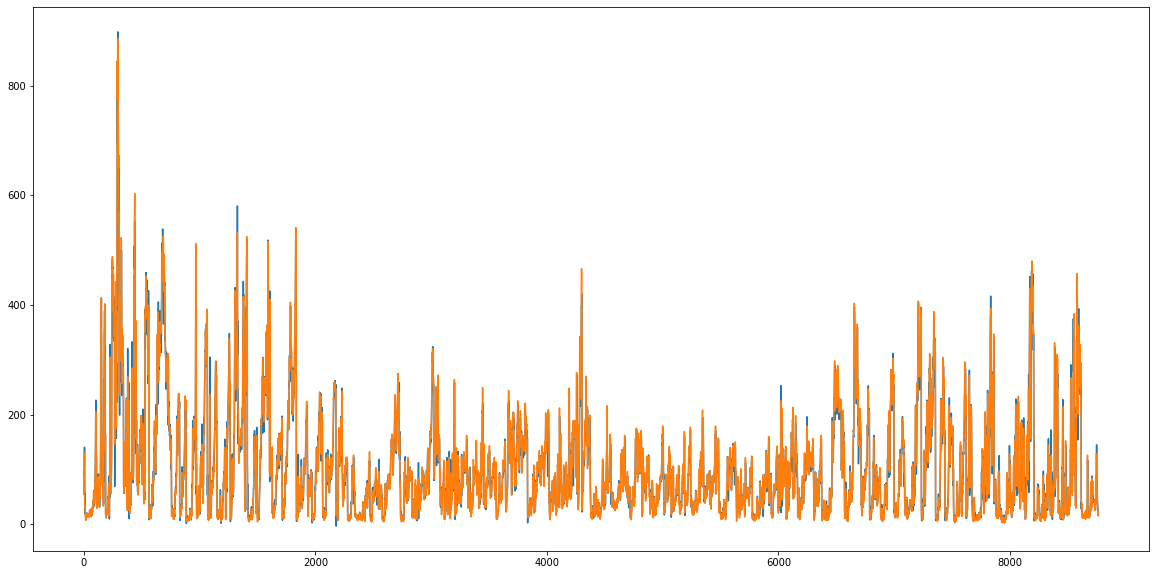

Iter:  31 train:  0.020581376278435145 val:  0.026281740399722364
Iter:  32 train:  0.021899194621189496 val:  0.024700746725487947
Iter:  33 train:  0.02076953101698188 val:  0.023714670933279086
Iter:  34 train:  0.021150008032714763 val:  0.02378503242505336
Iter:  35 train:  0.020751861838237174 val:  0.023734629357827386
Iter:  36 train:  0.020183490785276596 val:  0.025960090760881963
Iter:  37 train:  0.020050204219588894 val:  0.02415523937668684
Iter:  38 train:  0.020134556901911602 val:  0.0236934154521553
Iter:  39 train:  0.020205309429820777 val:  0.024460352259416302
Iter:  40 train:  0.020000924503101706 val:  0.023777376058044745
lr:  0.0008100000000000001
mse:  558.5996 mae:  13.0286045


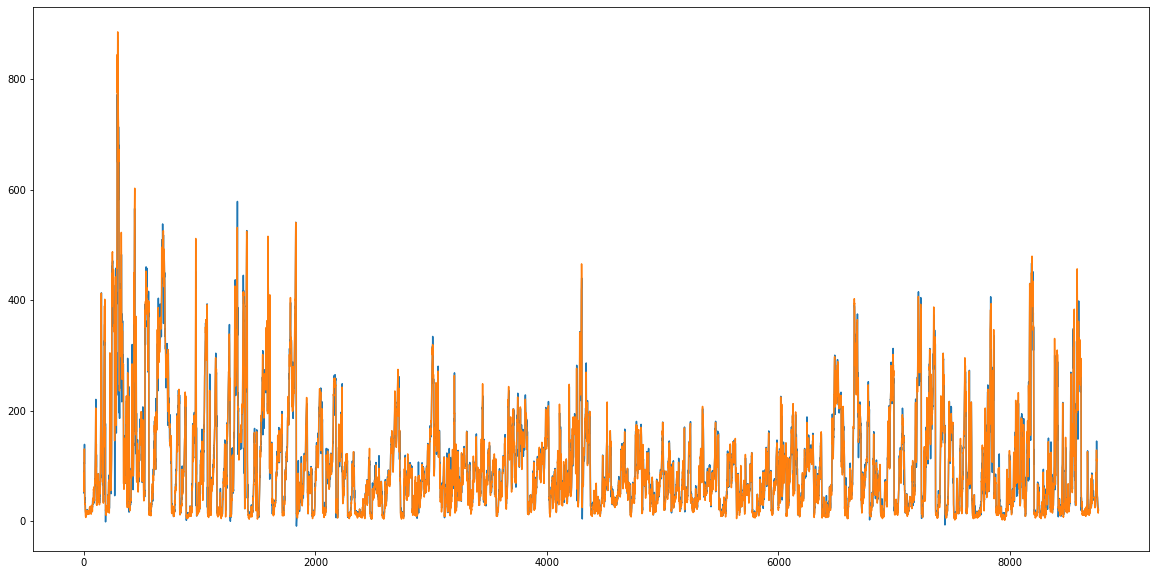

Iter:  41 train:  0.020271083959975778 val:  0.02415905201685393
Iter:  42 train:  0.01979110782788976 val:  0.025287233543171927
Iter:  43 train:  0.019327433978955855 val:  0.025763685264645245
Iter:  44 train:  0.01942775655151036 val:  0.024082815127223305
Iter:  45 train:  0.019410412478910816 val:  0.024795515861072284
Iter:  46 train:  0.01920655053913667 val:  0.024753881316805178
Iter:  47 train:  0.018806485202454027 val:  0.024682633968251155
Iter:  48 train:  0.01884503996325093 val:  0.024660549880847264
Iter:  49 train:  0.018656897710613744 val:  0.024846881746581572
Iter:  50 train:  0.018511669141800698 val:  0.025006829107365673
lr:  0.0008100000000000001
mse:  617.8599 mae:  13.534068


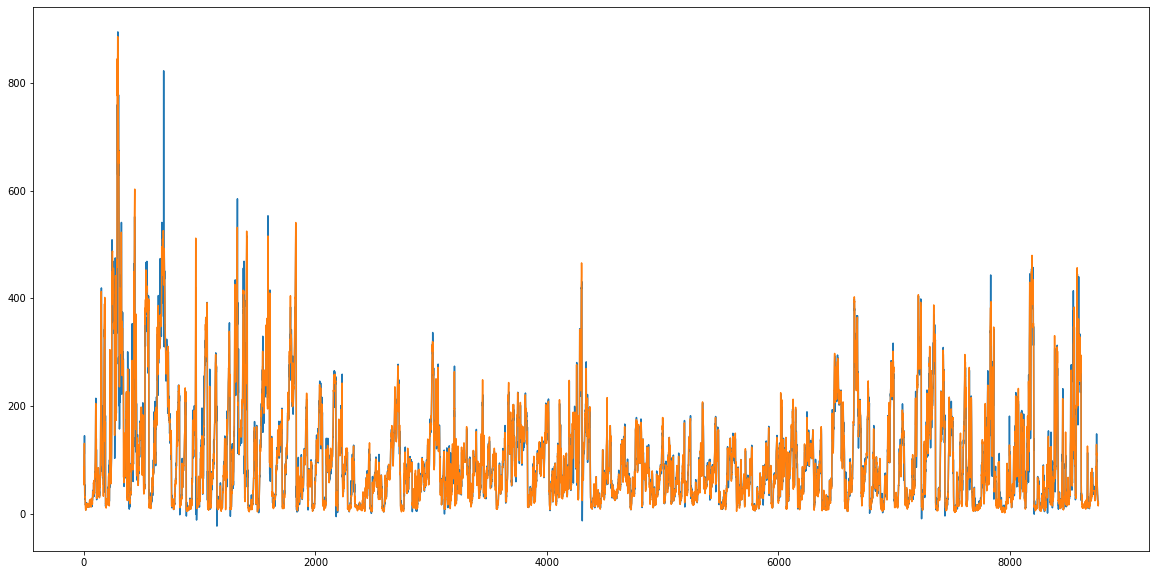

Iter:  51 train:  0.01845652567435586 val:  0.027598961437797703
Iter:  52 train:  0.01804422479346853 val:  0.02505716672291795


In [30]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_full_lstm_pm25.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("lr: ", opt.param_groups[0]["lr"])
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [32]:
model.load_state_dict(torch.load("imv_full_lstm_pm25.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [36]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [37]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [38]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [39]:
mse, mae

(436.9099, 11.378988)

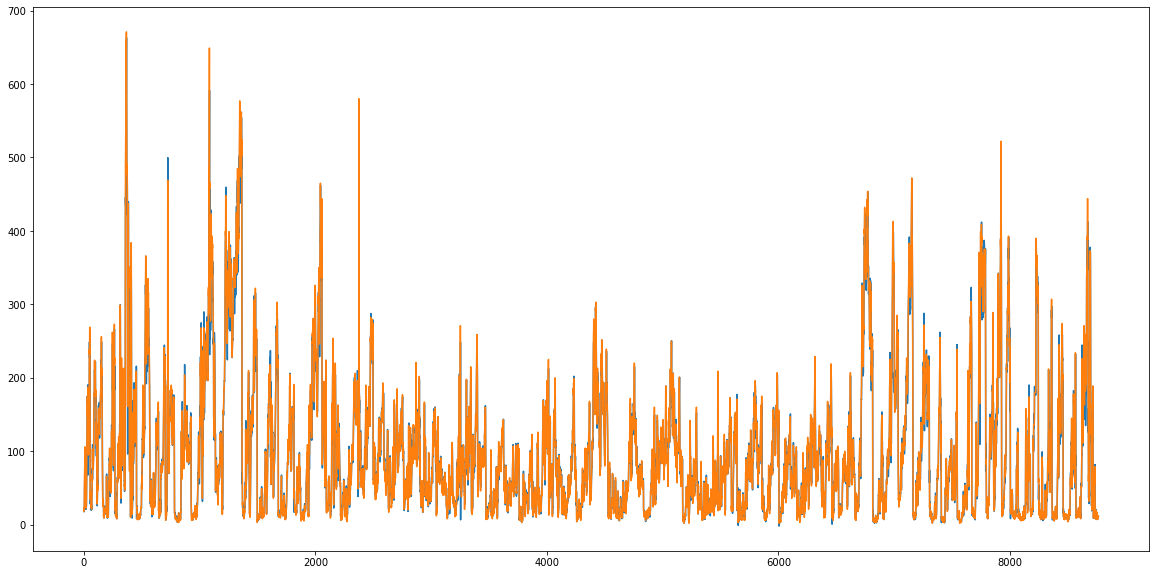

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [41]:
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [42]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [43]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [44]:
alphas = alphas.transpose(1, 0)

In [45]:
cols

['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_0',
 'cbwd_1',
 'cbwd_2',
 'cbwd_3']

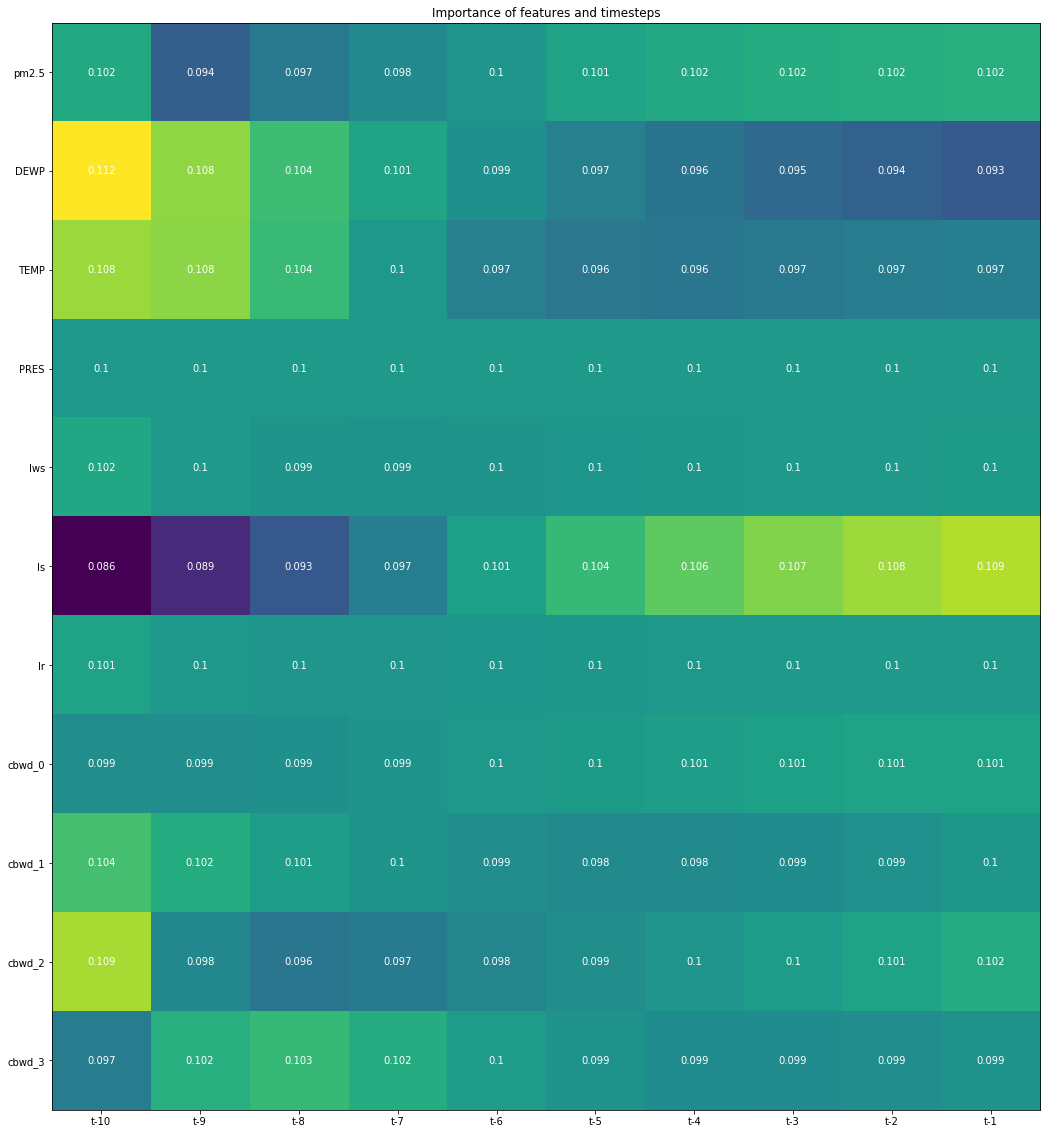

In [47]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7faae046f3c8>,
 <a list of 11 Text xticklabel objects>)

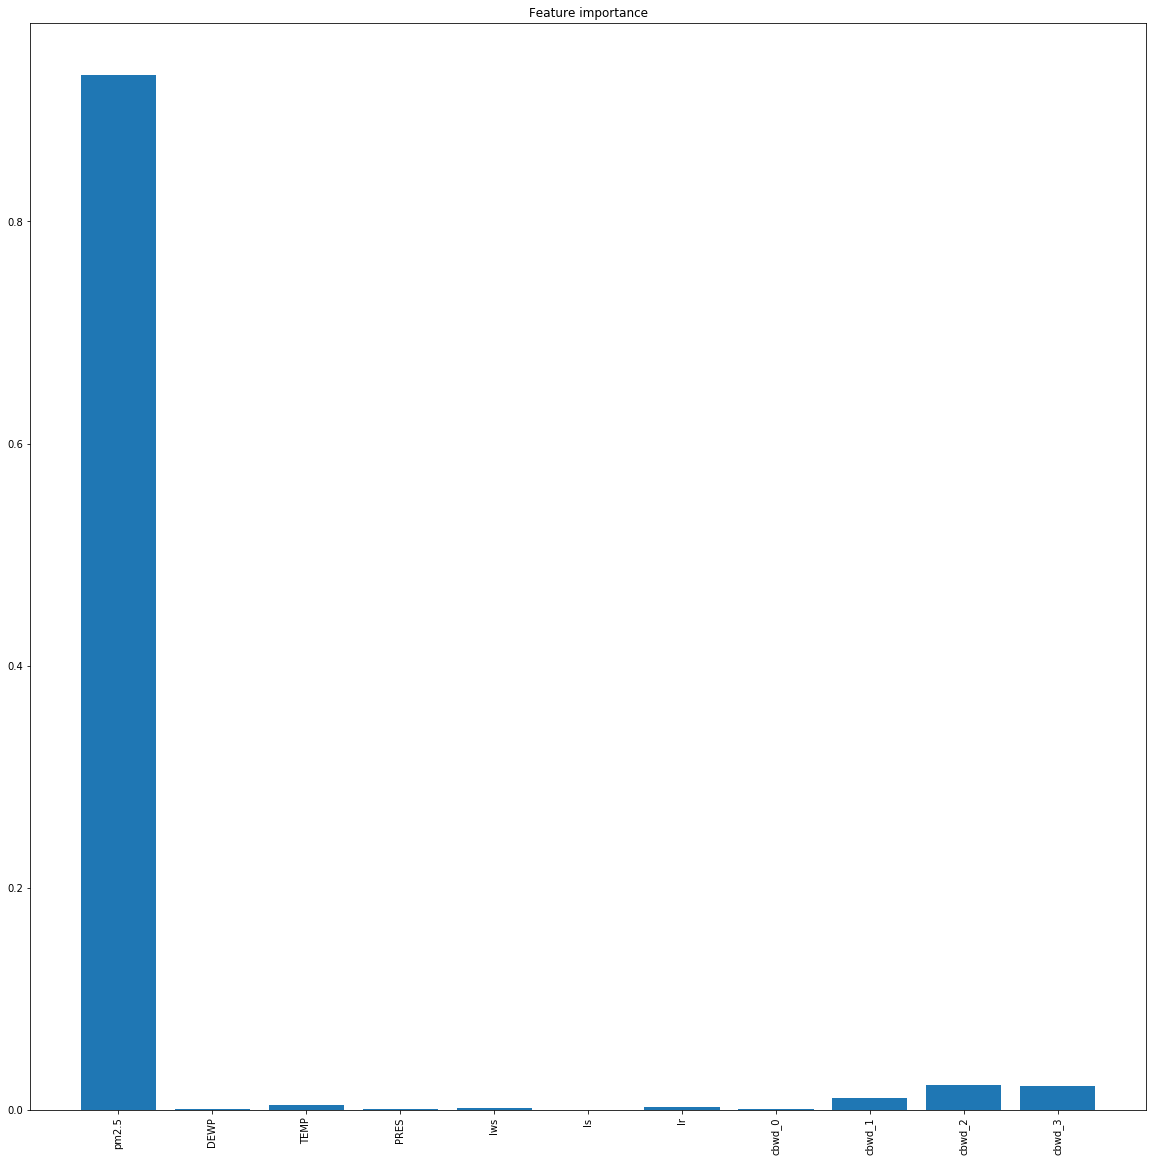

In [48]:
plt.figure(figsize=(20, 20))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=list(cols), rotation=90)